In [16]:
!date

Tue Jul 27 22:07:56 PDT 2021


# Subclass DE isoform only [GABA]

In [17]:
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import scanpy as sc
from scipy.stats import ks_2samp, ttest_ind
import ast
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings('ignore')


import sys
sys.path.append('../../../../BYVSTZP_2020/dexpress')
from dexpress import dexpress, utils, plot

#sys.path.append('../../../BYVSTZP_2020/trackfig')
#from trackfig.utils import get_notebook_name
#from trackfig.trackfig import trackfig 

#TRACKFIG = "../../../../BYVSTZP_2020/trackfig.txt"
#NB = get_notebook_name()

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [18]:
subclass_cmap = pd.read_csv('../../metadata_files/CTX_Hip_anno_SSv4.csv', index_col='subclass_label',usecols=['subclass_label','subclass_color'])
subclass_cmap = subclass_cmap.drop_duplicates()
subclass_cmap = subclass_cmap.subclass_color.apply(lambda x: mcolors.to_rgb(x) )
subclass_cmap = subclass_cmap.to_dict()

In [19]:
gene = anndata.read_h5ad("../../../data/notebook/revision/gene.h5ad")
isoform = anndata.read_h5ad("../../../data/notebook/revision/isoform.h5ad")

In [20]:
isoform = isoform[:,isoform.var.sort_values("gene_id").index]
gene = gene[:,gene.var.sort_values("gene_id").index]

In [21]:
isoform = isoform[isoform.obs.eval("subclass_label != 'L5 IT'").values]
gene = gene[gene.obs.eval("subclass_label != 'L5 IT'").values]

In [22]:
print(isoform.shape)
print(gene.shape)

(18175, 81527)
(18175, 26154)


In [23]:
gene          = gene[gene.obs.class_label=="GABAergic"]
isoform = isoform[isoform.obs.class_label=="GABAergic"]

In [24]:
%%time
mat           = gene.layers["log1p"].todense()
components    = gene.obs.cell_id.values
features      = gene.var.gene_name.values
assignments   = gene.obs.subclass_label.values

unique = np.unique(assignments)
nan_cutoff = 0.9 # of elements in cluster
corr_method = "bonferroni"


p_raw, stat, es, nfeat = dexpress.dexpress(mat, components, features, assignments, nan_cutoff=nan_cutoff)
p_raw = p_raw/2
p_corr = utils.correct_pval(p_raw, nfeat, corr_method)

s = stat

markers_gene = dexpress.make_table(assignments, features, p_raw, p_corr, es)

# convert the 0 pvalues to the smallest possible float
markers_gene["p_corr"][markers_gene.eval("p_corr == 0").values] = sys.float_info.min
markers_gene = markers_gene.query("es > 0")

27-Jul-21 22:13:28 - 1 of 7 assignments: Lamp5
27-Jul-21 22:13:41 - 2 of 7 assignments: Meis2
27-Jul-21 22:13:43 - 3 of 7 assignments: Pvalb
27-Jul-21 22:13:44 - 4 of 7 assignments: Sncg
27-Jul-21 22:13:45 - 5 of 7 assignments: Sst
27-Jul-21 22:13:46 - 6 of 7 assignments: Sst Chodl
27-Jul-21 22:13:47 - 7 of 7 assignments: Vip


CPU times: user 5.02 s, sys: 25.6 s, total: 30.7 s
Wall time: 31.1 s


In [25]:
%%time
mat         = isoform.layers["log1p"].todense() # expects dense matrix
components  = isoform.obs.cell_id.values
features    = isoform.var.transcript_name.values
assignments = isoform.obs.subclass_label.values

unique = np.unique(assignments)
nan_cutoff = 0.9 # of elements in cluster
corr_method = "bonferroni"


p_raw, stat, es, nfeat = dexpress.dexpress(mat, components, features, assignments, nan_cutoff=nan_cutoff)
p_raw = p_raw/2
p_corr = dexpress.correct_pval(p_raw, nfeat, corr_method)

s = stat

markers_isoform = dexpress.make_table(assignments, features, p_raw, p_corr, es)

# convert the 0 pvalues to the smallest possible float
markers_isoform["p_corr"][markers_isoform.eval("p_corr == 0").values] = sys.float_info.min
markers_isoform = markers_isoform.query("es > 0")

27-Jul-21 22:13:57 - 1 of 7 assignments: Lamp5
27-Jul-21 22:14:33 - 2 of 7 assignments: Meis2
27-Jul-21 22:14:38 - 3 of 7 assignments: Pvalb
27-Jul-21 22:14:42 - 4 of 7 assignments: Sncg
27-Jul-21 22:14:46 - 5 of 7 assignments: Sst
27-Jul-21 22:14:50 - 6 of 7 assignments: Sst Chodl
27-Jul-21 22:14:54 - 7 of 7 assignments: Vip


CPU times: user 8.17 s, sys: 1min, total: 1min 8s
Wall time: 1min 8s


# Look at isoform markers

In [40]:
alpha = 0.01
markers_isoform = markers_isoform.query(f"p_corr < {alpha}")
markers_isoform.sort_values("es").tail()

,index,name,p_raw,p_corr,es
421044,Sst Chodl,Crhbp-202_ENSMUST00000221025.2,8.1362e-25,2.72726e-21,6.69804
479032,Sst Chodl,Pcp4-201_ENSMUST00000061739.9,1.29603e-34,4.34428e-31,6.71945
439547,Sst Chodl,Npy-201_ENSMUST00000031843.7,2.1441e-75,7.18703e-72,7.20484
410689,Sst Chodl,Sst-201_ENSMUST00000004480.5,2.63675e-145,8.83838e-142,8.0117
329162,Sst,Sst-201_ENSMUST00000004480.5,0,2.22507e-308,8.86244


In [41]:
markers_gene[markers_gene.name.str.contains('Crhbp')]

,index,name,p_raw,p_corr,es
133478,Sst Chodl,Crhbp_ENSMUSG00000021680.9,7.61513e-34,2.80085e-30,6.58665


In [42]:
specific_cluster = "Sst Chodl"
specific_isoform = "Crhbp-202_ENSMUST00000221025.2"
specific_gene = "".join(specific_isoform.split("-")[:-1])

In [43]:
specific_gene

'Crhbp'

In [44]:
gene.var[gene.var.gene_name.str.contains(specific_gene+"_")].gene_name.values

['Crhbp_ENSMUSG00000021680.9']
Categories (26154, object): ['5S_rRNA_ENSMUSG00000118681.1', '5S_rRNA_ENSMUSG00000118725.1', '5S_rRNA_ENSMUSG00000118727.1', '5S_rRNA_ENSMUSG00000118747.1', ..., 'n-R5s25_ENSMUSG00000064857.3', 'n-R5s41_ENSMUSG00000064959.3', 'n-R5s173_ENSMUSG00000064554.3', 'n-R5s185_ENSMUSG00000065887.2']

In [45]:
isoform.var[isoform.var.gene_name.str.contains(specific_gene+"_")].transcript_name.values

array(['Crhbp-201_ENSMUST00000045583.9', 'Crhbp-202_ENSMUST00000221025.2'],
      dtype=object)

In [46]:
specific_gene = gene.var[gene.var.gene_name.str.contains(specific_gene+"_")].gene_name.values[0]

In [47]:
def violinplot(data, ax, **kwd): 
    xticklabels = kwd.get("xticklabels", [])
    xticks = kwd.get("xticks", [])
    selected = kwd.get("selected", None)
    color = kwd.get("color", "grey")
    
    if  len(xticks)==0: xticks = np.arange(len(data))+1;
    if  len(xticklabels)==0: xticklabels = np.arange(len(data))+1;
    assert(len(xticks) == len(xticklabels))
        
    violins = ax.violinplot(data, positions=xticks, showmeans=False, showmedians=False, showextrema=False)
    
    for vidx, v in enumerate(violins['bodies']):
        v.set_facecolor(color)
        v.set_edgecolor('black')
        v.set_alpha(1)
        if selected == vidx:
            v.set_facecolor("#D43F3A")

            
    
    for didx, d in enumerate(data):
        x = xticks[didx]
        xx = np.random.normal(x, 0.04, size=len(d))
        
        # actual points
        ax.scatter(xx, d, s = 5, color="white", edgecolor="black", linewidth=1)
        
        # mean and error bars
        mean = np.mean(d)
        stdev = np.sqrt(np.var(d))
        ax.scatter(x, mean, color="lightgrey", edgecolor="black", linewidth=1, zorder=10)    
        ax.vlines(x, mean - stdev, mean+stdev, color='lightgrey', linestyle='-', lw=2, zorder=9)
        
    ax.set(**{"xticks": xticks, "xticklabels":xticklabels})
    ax.set_xticklabels(labels, rotation=45, ha="right")

    
    return ax


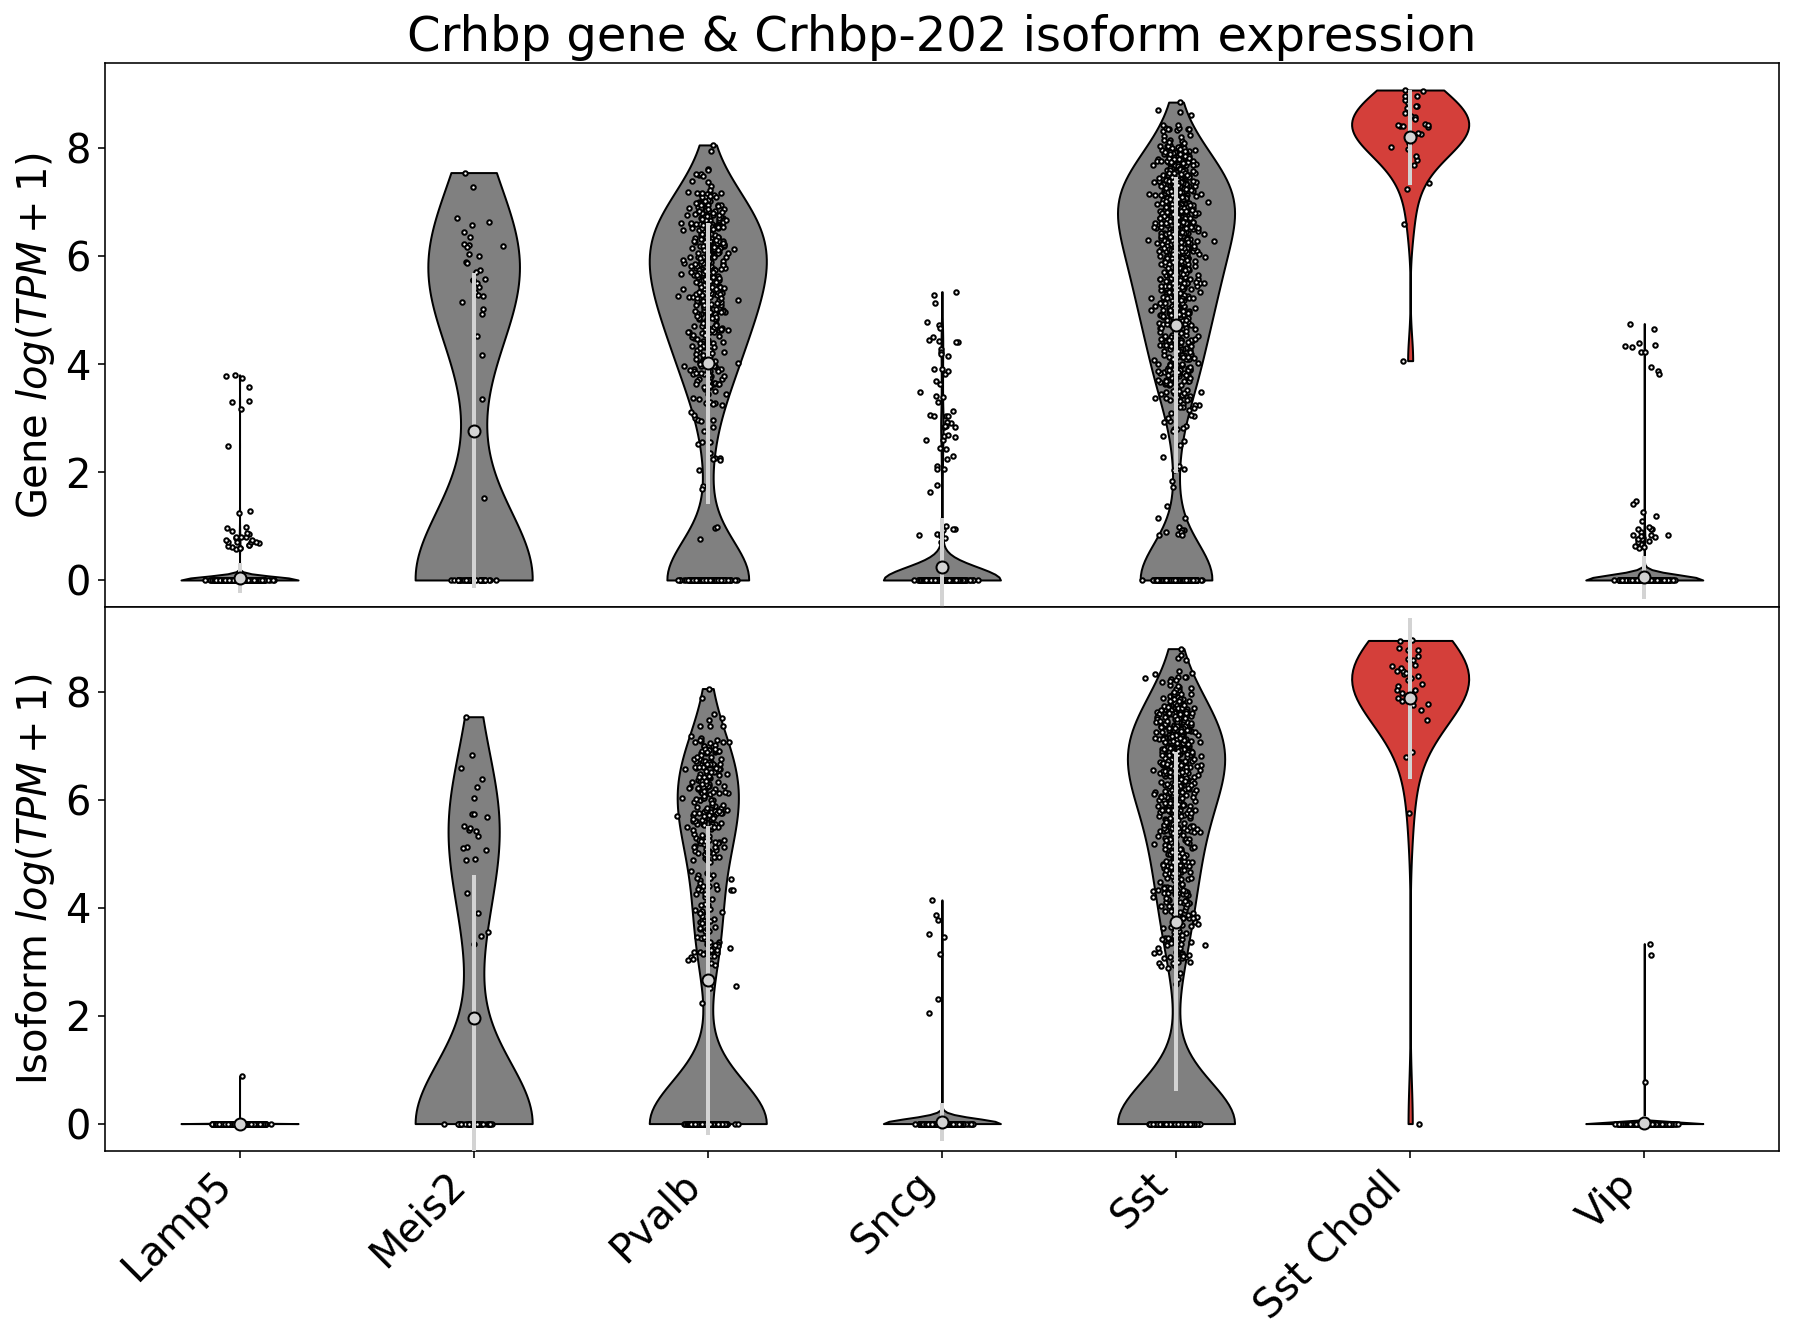

In [48]:
fig, ax = plt.subplots(figsize=(15,10), nrows=2, sharex=True)
fig.subplots_adjust(hspace=0, wspace=0)

# Declare
unique = np.unique(gene.obs.subclass_label)
unique = np.delete(unique, np.where(unique=="Low Quality"))
labels = unique
lidx = np.arange(1, len(labels)+1)  # the label locations
midx = np.where(unique==specific_cluster)[0][0]

## Plot
# Gene
x = []
for c in unique:
    x.append(np.asarray(gene[gene.obs.subclass_label==c][:,gene.var.gene_name==specific_gene].layers["log1p"].todense()).reshape(-1).tolist())

violinplot(x, ax[0], selected=midx)


######## Isoform
x = []
for c in unique:
    x.append(np.asarray(isoform[isoform.obs.subclass_label==c][:,isoform.var.transcript_name==specific_isoform].layers["log1p"].todense()).reshape(-1).tolist())

violinplot(x, ax[1], selected=midx, xticks=lidx, xticklabels=labels)

ax[0].set(**{
    "title":"{} gene & {} isoform expression".format(specific_gene.split("_")[0], specific_isoform.split("_")[0]),
    "ylabel":"Gene $log(TPM + 1)$",
    "ylim": -0.5

})
ymin, ymax = ax[0].get_ylim()
ax[1].set(**{
    "ylabel":"Isoform $log(TPM + 1)$",
    "ylim": (ymin, ymax),
})

plt.savefig("../../../figures/subclass_DE_isoform_only_violin_{}-GABA.png".format(specific_gene.split("_")[0]), bbox_inches='tight',dpi=300)
plt.show()

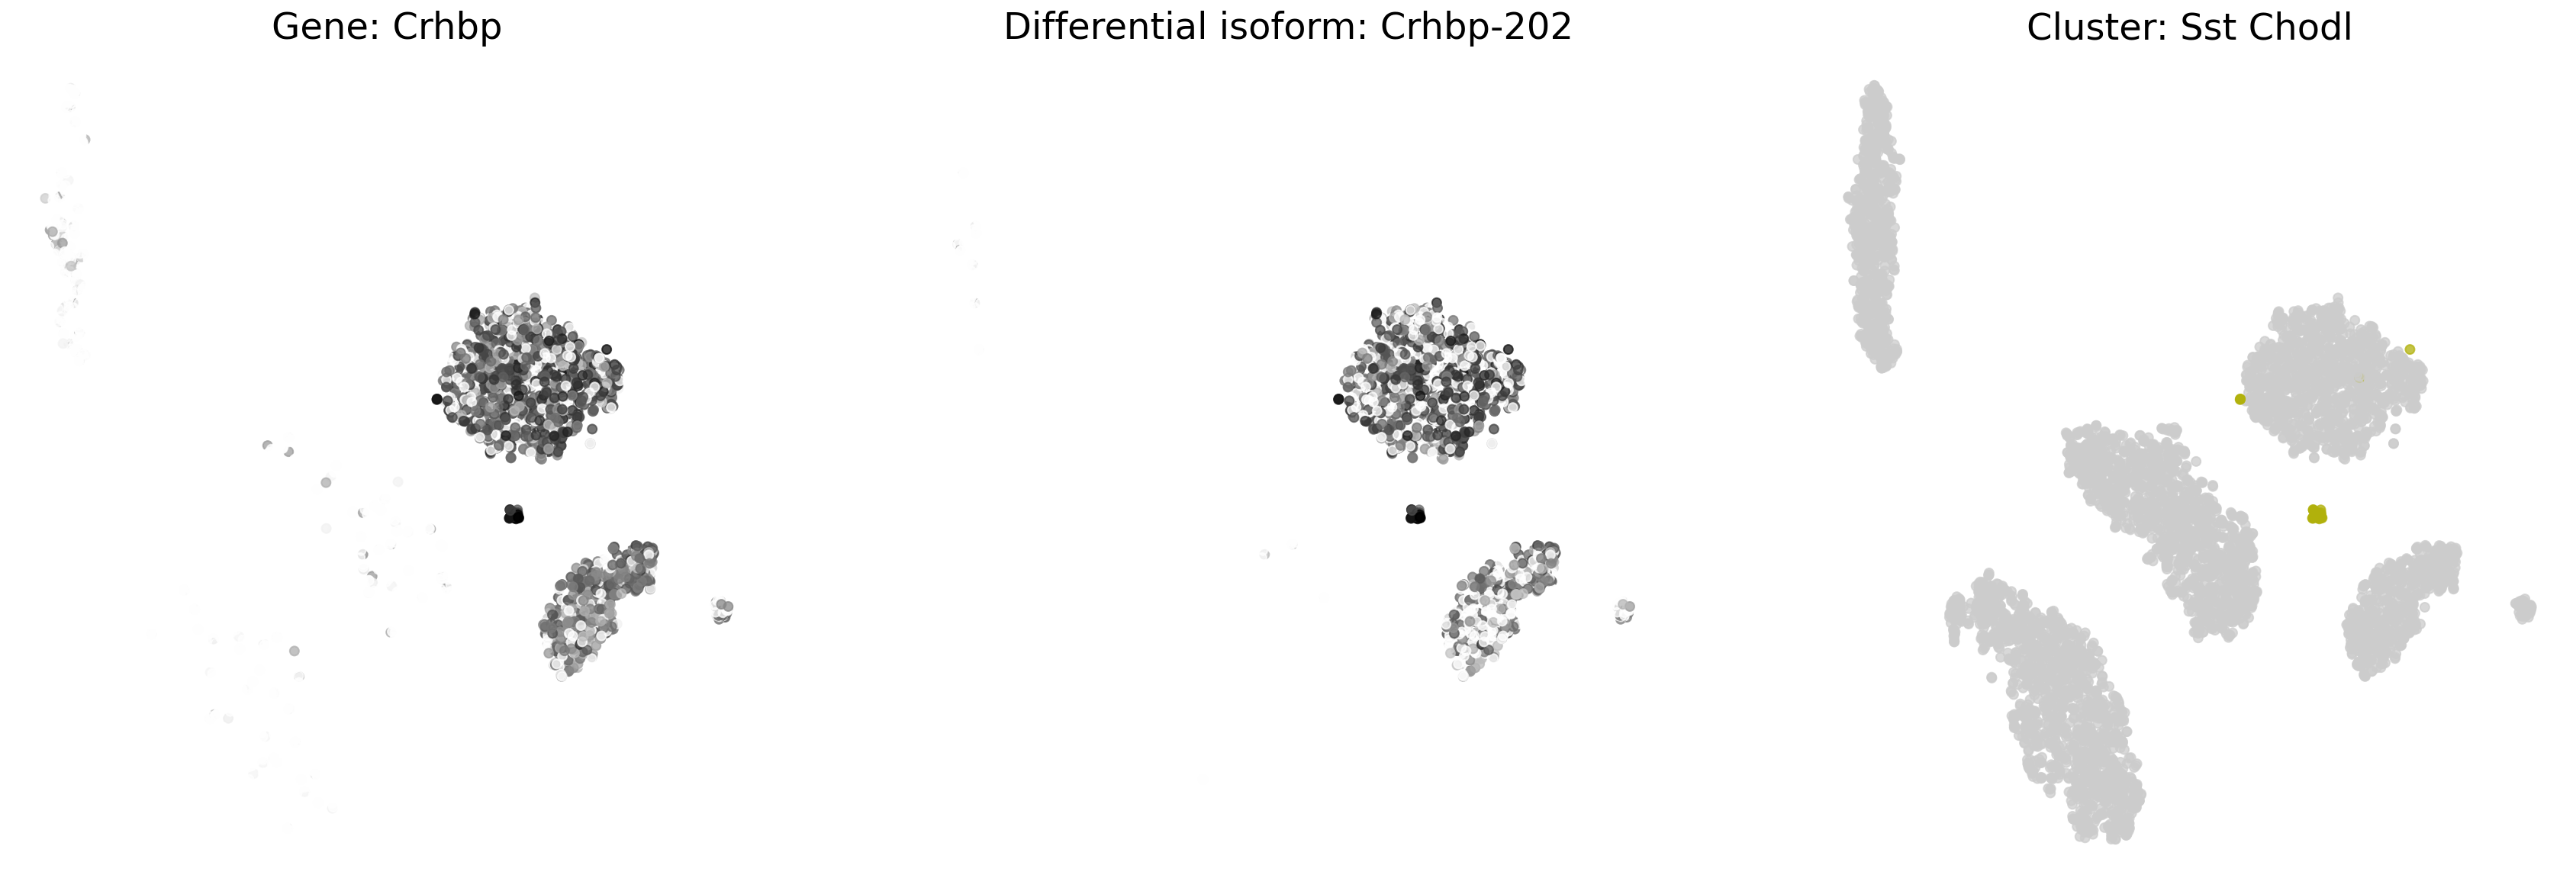

In [49]:
complement_color = (0.8, 0.8, 0.8, 1.0)

fig, ax = plt.subplots(figsize=(30,10), ncols=3)

x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = np.asarray(gene[:, gene.var.gene_name==specific_gene].layers["log1p"].todense()).reshape(-1)
cmap="Greys"
alpha = 0.75
ax[0].set_title("Gene: {}".format(specific_gene.split("_")[0]))

ax[0].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[0].set_axis_off()


x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = np.asarray(isoform[:, isoform.var.transcript_name==specific_isoform].layers["log1p"].todense()).reshape(-1)
cmap="Greys"
alpha = 0.75
ax[1].set_title("Differential isoform: {}".format(specific_isoform.split("_")[0]))

ax[1].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[1].set_axis_off()

x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = gene.obs["subclass_label"]==specific_cluster
c = gene.obs["subclass_label"].astype(str).map(subclass_cmap).tolist()
indices = np.where(gene.obs["subclass_label"]!=specific_cluster)[0]
replacements=[complement_color]*len(indices)
for (index, replacement) in zip(indices, replacements):
    c[index] = replacement
alpha=0.75
cmap="nipy_spectral_r"

ax[2].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[2].set_axis_off()
ax[2].set_title("Cluster: {}".format(specific_cluster.split("_")[0]))
plt.savefig("../../../figures/subclass_DE_isoform_only_nca_{}-GABA.png".format(specific_gene.split("_")[0]), bbox_inches='tight',dpi=300)
plt.show()

In [50]:
identified_isoforms = markers_isoform["name"].explode().astype(str)

In [51]:
identified_genes = identified_isoforms.apply(lambda x: x.split("-")[0])

In [52]:
print("{} isoforms from {} genes identified.".format(identified_isoforms.shape[0], identified_genes.nunique()))

5939 isoforms from 2652 genes identified.


In [53]:
markers_isoform.to_csv("../../../tables/unordered/subclass_DE_isoform_only-GABA.csv")